# Federated Learning: Download Trained Model

In the "Part 01 - Create Plan" notebooks we created the model, training plan, and averaging plan, and then hosted all of them in PyGrid.

Imagine, such hosted FL model was trained using client libraries, SwiftSyft, KotlinSyft, syft.js, or FL client from the "[Part 02 - Execute Plan](Part%2002%20-%20Execute%20Plan.ipynb)" notebook.

In this notebook, we'll download model checkpoints and test them against MNIST dataset.

_NOTE_: Technically such evaluation is not correct since we don't have train/test split -
 clients train on randomly chosen samples from the MNIST dataset.
 However, since clients train only on a very small portion of samples,
 we can still get a sense of how well the model generalises to the rest of the dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import torch as th
from torch import nn
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

import syft as sy
from syft.grid.clients.static_fl_client import StaticFLClient
from syft.grid.exceptions import GridError

sy.make_hook(globals())

/home/marcel/Documents/Uni/susml/v2/PySyft/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marcel/Documents/Uni/susml/v2/PySyft/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marcel/Documents/Uni/susml/v2/PySyft/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/m


Setting up Sandbox...
Done!


Utility function that sets tensors as model weights (copied from Part 01 notebook):

In [2]:
def set_model_params(module, params_list, start_param_idx=0):
    """ Set params list into model recursively
    """
    param_idx = start_param_idx

    for name, param in module._parameters.items():
        module._parameters[name] = params_list[param_idx]
        param_idx += 1

    for name, child in module._modules.items():
        if child is not None:
            param_idx = set_model_params(child, params_list, param_idx)

    return param_idx

The model as in Part 01 notebook:

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 392)
        self.fc2 = nn.Linear(392, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

Load MNIST dataset.

In [4]:
batch_size = 64
mnist_dataset = th.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    drop_last=True,
)

Create client and model.

In [5]:
# Create FL client
client = StaticFLClient(id="test", address="127.0.0.1:5000")

# Create model
model = Net()
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (fc2): Linear(in_features=392, out_features=10, bias=True)
)

Define evaluation helper function that will check model accuracy against whole MNIST dataset.

In [6]:
def evaluate_model(name, version, checkpoint):
    """Test specified model against MNIST dataset"""
    model_params_state = client.get_model(name, version, checkpoint)
    model_params = model_params_state.tensors()

    # Load model params into the model
    set_model_params(model, model_params)

    # Test
    accuracies = []
    for batch_idx, (X, y) in enumerate(mnist_dataset):
        X = X.view(batch_size, -1)
        with th.no_grad():
            logits = model(X)
        preds = th.argmax(logits, dim=1)
        acc = preds.eq(y).float().mean()
        accuracies.append(acc.item())

    return np.mean(accuracies)

Let's get all model checkpoints and see how they were becoming better.

Testing checkpoint 1...Done (0.10757403948772679)
Testing checkpoint 2...Done (0.5054028815368197)
Testing checkpoint 3...Done (0.6340548292422625)
Testing checkpoint 4...Done (0.6691402081109925)
Testing checkpoint 5...Done (0.723352454642476)
Testing checkpoint 6...Done (0.7352921558164355)
Testing checkpoint 7...No more checkpoints to try


<BarContainer object of 6 artists>

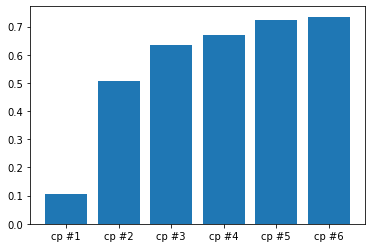

In [7]:
name = "mnist"
version = "1.0.0"
checkpoint = 1

checkpoints = []
accuracies = []

while True:
    try:
        print(f"Testing checkpoint {checkpoint}...", end="")
        accuracy = evaluate_model(name, version, checkpoint)
        print(f"Done ({accuracy})")
        checkpoints.append(f"cp #{checkpoint}")
        accuracies.append(accuracy)
        checkpoint += 1
    except GridError as err:
        # Model not found
        print("No more checkpoints to try")
        break

plt.bar(checkpoints, accuracies)

NOTE: Retrieving all checkpoints is done for the sake of model improvement demonstration.
To simply get the latest checkpoint, do `client.get_model(name, version)` or `client.get_model(name, version, "latest")`.